In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# 액션 정의
actions = [
    'skip', 'scroll', 'back', 'search', 'home'
]
# actions = [
#     # 'skip', 
#     'scroll', 
#     # 'back', 
#     # 'search', 
#     'home', 
#     # 'space', 
#     # 'up', 
#     'down', 
#     'next', 
#     'max'
# ]
# actions = [
#     'come', 
#     'away', 
#     'spin'
# ]

# 데이터 로드해서 하나로 합침
data = np.concatenate([
    np.load('dataset/seq_back_1673979408.npy'),
    np.load('dataset/seq_home_1673979408.npy'),
    np.load('dataset/seq_scroll_1673979408.npy'),
    np.load('dataset/seq_search_1673979408.npy'),
    np.load('dataset/seq_skip_1673979408.npy')
], axis=0)
# data = np.concatenate([
#     # np.load('dataset/seq_come_1673977897.npy'),
#     np.load('dataset/seq_down_1673978212.npy'),
#     np.load('dataset/seq_home_1673978212.npy'),
#     np.load('dataset/seq_max_1673978212.npy'),
#     np.load('dataset/seq_next_1673978212.npy'),
#     np.load('dataset/seq_scroll_1673978212.npy'),
#     # np.load('dataset/seq_search_1673978212.npy'),
#     # np.load('dataset/seq_skip_1673978212.npy'),
#     # np.load('dataset/seq_space_1673978212.npy'),
#     # np.load('dataset/seq_up_1673978212.npy')
# ], axis=0)

data.shape

(4339, 30, 100)

In [3]:
x_data = data[:, :, :-1] # 데이터셋은 라벨 값 제외
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(4339, 30, 99)
(4339,)


In [4]:
# 원핫인코딩: come이 0이면 1, 0, 0 으로
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

IndexError: index 7 is out of bounds for axis 1 with size 5

In [ ]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(7748, 30, 99) (7748, 10)
(861, 30, 99) (861, 10)


In [ ]:
#모델 정의

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]), # 1~2 : 윈도우 크기인 30, 랜드마크 등인  99
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                41984     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                                 
Total params: 44,394
Trainable params: 44,394
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습시키기

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
242/243 [============================>.] - ETA: 0s - loss: 67.9226 - acc: 0.2243
Epoch 1: val_acc improved from -inf to 0.38211, saving model to models\model.h5
243/243 [==============================] - 3s 10ms/step - loss: 67.8954 - acc: 0.2244 - val_loss: 19.4257 - val_acc: 0.3821 - lr: 0.0010
Epoch 2/200
240/243 [============================>.] - ETA: 0s - loss: 81.7480 - acc: 0.3410
Epoch 2: val_acc did not improve from 0.38211
243/243 [==============================] - 2s 9ms/step - loss: 81.5703 - acc: 0.3398 - val_loss: 37.2242 - val_acc: 0.3159 - lr: 0.0010
Epoch 3/200
241/243 [============================>.] - ETA: 0s - loss: 76.7740 - acc: 0.2081
Epoch 3: val_acc did not improve from 0.38211
243/243 [==============================] - 2s 9ms/step - loss: 76.5037 - acc: 0.2084 - val_loss: 16.5377 - val_acc: 0.2427 - lr: 0.0010
Epoch 4/200
237/243 [============================>.] - ETA: 0s - loss: 10.3332 - acc: 0.2244
Epoch 4: val_acc did not improve from 0.38211
2

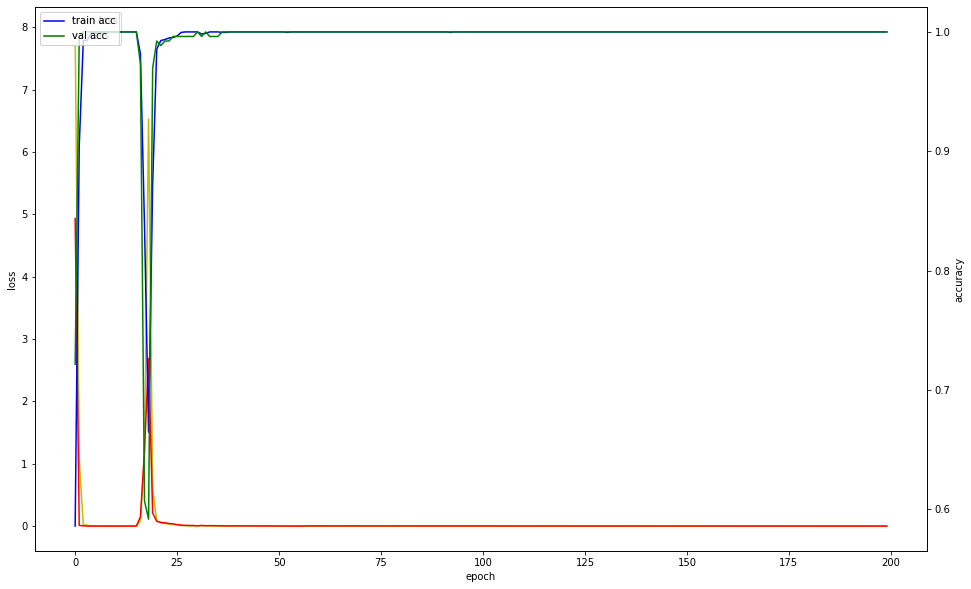

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

9/9 [==============================] - 0s 5ms/step


array([[[171,   0],
        [  0,  91]],

       [[178,   0],
        [  0,  84]],

       [[175,   0],
        [  0,  87]]], dtype=int64)